To solve the question: "Make a model, which allows estimating if a given customer will buy again something from the online shop in the next quarter", here are the general steps to follow:

1. Data Loading and Exploration
2. Data Preprocessing
3. Feature Engineering
4. Building and Training a Model
5. Evaluating Model Performance
6. Model Tuning & Optimization

Now, let's get into the detail of each step with Python code using common data science and machine learning libraries (pandas, numpy, sklearn, etc.):

# Data Loading and Exploration:
Here, we first import necessary libraries such as pandas, numpy, matplotlib and datetime. The data is loaded from a CSV file and a snapshot of the data is displayed using df.head(). The data includes information about invoices, customer IDs, quantities of purchases, prices, and the countries of the customers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Load the data
df = pd.read_csv('online_retail_II.csv')

# Explore the data
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


From data exploration in question 1 we already know that there are customers whose Customer ID are missing, and there are negative Quantity values which we assumed to be returns

# Data Preprocessing:
In this section, we convert the 'InvoiceDate' from object type to datetime. Any rows with missing customer IDs are dropped to ensure data integrity. The data is sorted by 'InvoiceDate' to maintain chronological order.

We will consider customers who have made at least one purchase in the past.

Regarding the missing Customer IDs, we can fill in missing Customer IDs based on the Invoice Number. but this approach assumes that all items within the same invoice are purchased by the same customer, which might not always be the case. So we should carefully validate this assumption by asking the stakeholfers before applying it. For now we just drop the rows with the missing Customer ID.

In [2]:
# Convert InvoiceDate from object to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Filter out rows with missing customer IDs
df = df.dropna(subset=['Customer ID'])

# Sort data based on the date
df = df.sort_values('InvoiceDate').reset_index(drop=True)

# Feature Engineering:
A binary variable 'PurchasedNextQuarter' is created to indicate if a customer made a purchase in the subsequent quarter. Additionally, another binary variable 'HasReturned' is created to indicate if the customer has ever returned an item. Then, we group the data by 'Customer ID' and calculate various aggregated metrics. This results in a DataFrame where each row represents a unique customer. We'll use a 3-month (a quarter) as our threshold.

In [3]:
# Create a binary variable for each customer representing whether they make a purchase in the subsequent quarter
df['PurchasedNextQuarter'] = 0

# Use shift to check if a customer makes a purchase in the subsequent quarter
df['PurchasedNextQuarter'] = (df.sort_values('InvoiceDate')
                                .groupby('Customer ID')['InvoiceDate']
                                .shift(-1) - df['InvoiceDate'] <= pd.Timedelta(90, unit='D')).astype(int)

# Create a separate feature for returns
df['HasReturned'] = df.groupby('Customer ID')['Quantity'].apply(lambda x: (x < 0)).astype(int).values

We see that the same Customer IDs have made several purchases. Each row represents a different purchase made by the customer, so it's natural for a customer to have multiple rows if they've made multiple purchases.

when we're engineering features and building a model to predict future behavior, we'll want to summarize the data at the customer level. This means each Customer ID should be unique in our modeling dataset.

So for example, instead of using 'Quantity' and 'UnitPrice' as they are, we want to create aggregated features such as 'TotalQuantity', 'AverageUnitPrice', etc., for each customer:

In [4]:
# Group by CustomerID and calculate aggregate metrics
customer_data = df.groupby('Customer ID').agg({
    'Quantity': 'sum',
    'Price': 'mean',
    'InvoiceDate': ['min', 'max'],  # The first and last purchase date can be useful
    'PurchasedNextQuarter': 'max',  # Any purchase in next quarter counts
    'HasReturned': 'max' # any return by a customer
})

# Flatten the column index
customer_data.columns = ['_'.join(col).strip() for col in customer_data.columns.values]

In [5]:
customer_data

,Quantity_sum,Price_mean,InvoiceDate_min,InvoiceDate_max,PurchasedNextQuarter_max,HasReturned_max
Customer ID,,,,,,
12346.0,52,12.092500,2009-12-14 08:34:00,2011-01-18 10:17:00,1,1
12347.0,3286,2.546087,2010-10-31 14:20:00,2011-12-07 15:52:00,1,1
12348.0,2714,3.786275,2010-09-27 14:59:00,2011-09-25 13:13:00,1,0
12349.0,1619,8.358833,2009-12-04 12:49:00,2011-11-21 09:51:00,1,0
12350.0,197,3.841176,2011-02-02 16:01:00,2011-02-02 16:01:00,1,0
...,...,...,...,...,...,...
18283.0,1733,1.744168,2010-02-19 17:16:00,2011-12-06 12:02:00,1,1
18284.0,493,4.003103,2010-10-04 11:33:00,2010-10-06 12:31:00,1,0
18285.0,145,8.350000,2010-02-17 10:24:00,2010-02-17 10:24:00,1,0


In [6]:
customer_data.PurchasedNextQuarter_max.value_counts()

PurchasedNextQuarter_max
1    5787
0     155
Name: count, dtype: int64

There is a big imbalance in our dataset so we will use resampling techniques in the model building section.

Specifically we use oversampling in which we increase the number of samples in the minority class by duplicating examples or generating synthetic examples. One popular method for over-sampling is SMOTE (Synthetic Minority Over-sampling Technique).

# Building and Training a Model
Here, we have chosen a few features ('Quantity_sum', 'Price_mean', 'HasReturned_max') to train the RandomForestClassifier model. Before that, you handle class imbalance by using SMOTE (Synthetic Minority Over-sampling Technique) to oversample the minority class. The feature values are then scaled using StandardScaler. The data is split into a training set and a test set, and the RandomForestClassifier model is trained on the training data.

We tried LogisticRegression, RandomForestClassifier, and GradientBoostingClassifier models and RandomForestClassifier resulted in highest ROC AUC metric out of the box, so we stick to that one.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Assume customer_data is your DataFrame after aggregation
features = ['Quantity_sum', 'Price_mean', 'HasReturned_max']
target = 'PurchasedNextQuarter_max'

X = customer_data[features]
y = customer_data[target]

# Oversample the minority class using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Scaling the feature values
scaler = StandardScaler()
X_res = scaler.fit_transform(X_res)

# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Initialize and train a logistic regression model
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

# Evaluating Model Performance:
The performance of the model is evaluated by using various metrics such as accuracy, precision, recall, and ROC AUC. These metrics help in understanding how well the model performs in predicting the correct classes.

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'ROC AUC: {roc_auc}')

Accuracy: 0.9481641468682506
Precision: 0.9533721898417985
Recall: 0.9470636889991728
ROC AUC: 0.9482153888033839


# Model Tuning & Optimization:
For RandomForestClassifier, we use optuna package for hyper parameter optimization. In this section, we use Optuna, a hyperparameter optimization framework, to find the optimal parameters for the RandomForestClassifier model. You then retrain the model with these optimal parameters and recalculate the performance metrics.

In [14]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    clf = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    return cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc').mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [16]:
best_params = study.best_params
print(best_params)

{'n_estimators': 469, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 2}


In [17]:
rf_model_opt = RandomForestClassifier(**best_params)
rf_model_opt.fit(X_train, y_train)

RandomForestClassifier(max_depth=22, min_samples_leaf=2, min_samples_split=3,
                       n_estimators=469)

In [19]:
# Make predictions
y_pred = rf_model_opt.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'ROC AUC: {roc_auc}')

Accuracy: 0.9498920086393089
Precision: 0.9596299411269975
Recall: 0.9437551695616212
ROC AUC: 0.950177765612637


We can see a small improvement in our metrics using the hyperparameter optimizatin

# Feature Importances 
Lastly, we plot a bar graph to show the importances of each feature in the trained RandomForestClassifier model. This plot gives insights into which features are most informative in the prediction task.

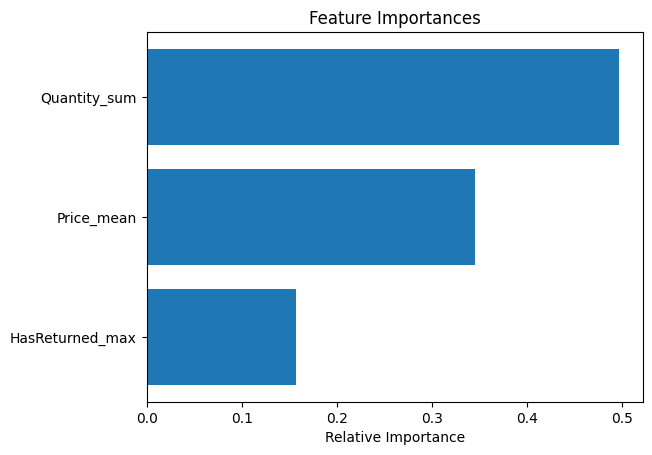

In [34]:
# Get feature importances
importances = rf_model_opt.feature_importances_

# Sort the feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]

plt.figure()
# Create a bar plot
plt.barh(range(X_train.shape[1]), importances, align='center')
plt.yticks(range(X_train.shape[1]), features)
plt.xlabel('Relative Importance')
plt.title('Feature Importances')

# Display the plot
plt.gca().invert_yaxis()
plt.show()

We see that the sum of quantity of the products bought plays the most important role in indicating if a customer will make a new purchase in the next quarter.